In [115]:
from __future__ import division

from pylab import *
import scipy
import time

import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

import utils
import hrr_utils

import string

from scipy import spatial
from matplotlib.collections import LineCollection
%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [116]:
N=20000

In [117]:
alphabet = string.ascii_lowercase + "#."

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.' 
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1



def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = ngram_encode_cl(pair[1], dic1, 3)
        past2 = ngram_encode_cl(pair[1], dic2, 3)
        pres1 = ngram_encode_cl(pair[0], dic1, 3)
        pres2 = ngram_encode_cl(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def reg_train(tv, past, present):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, y3, title=None):

    fig = plt.figure()
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    plt.plot(x, y3, label="random")
    fig.suptitle(title, fontsize=20)
    plt.xlabel('number of words', fontsize=18)
    plt.ylabel('average dot product', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()
    #fig.savefig('test.jpg')

In [118]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2./3.

train_reg = regular[0:int(train_frac*len(regular))]
train_irreg = irregular[0:int(train_frac*len(irregular))]


test_reg = regular[int(train_frac*len(regular)):]
test_irreg = irregular[int(train_frac*len(irregular)):]

#dic1 = hrr_utils.GenerateDefaultDictionary(N)
#dic2 = hrr_utils.GenerateDefaultDictionary(N)

D = len(alphabet)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

regular.extend(irregular)
verbs = regular

In [119]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

## Trigram dictionary, unregularized


In [120]:
tst = time.time()

psi = np.zeros(N)
psi = train(psi, trainpast2[0], trainpres1[0])

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = train(psi, trainpast2[k], trainpres1[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/trigram_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  588.737639189
data/trigram_dict-unreg-N=20000-W=1758-170307.npz


figures/trigram_dict-unreg-N=20000-W=1758-170307


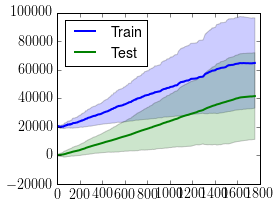

In [121]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)
test_mean = test_hist.mean(axis=1)
random_mean = random_hist.mean(axis=1)

train_std = np.nanstd(train_hist, axis=1) #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1) #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1) #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper left')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Dictionary, Unregularized')

xlim([0, 2000])

plt.tight_layout()

fname =  ('figures/trigram_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

## Trigram dictionary, regularized


In [122]:
tst = time.time()

cycle=1
psi = np.zeros(N)
psi = reg_train(psi, trainpast2[0], trainpres1[0])

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = reg_train(psi, trainpast2[k], trainpres1[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/trigram_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  581.281916142
data/trigram_dict-reg-N=20000-W=1758-170307.npz


figures/trigram_dict-reg-N=20000-W=1758-170307


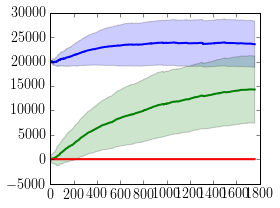

In [123]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)
test_mean = test_hist.mean(axis=1)
random_mean = random_hist.mean(axis=1)

train_std = np.nanstd(train_hist, axis=1) #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1) #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1) #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)


xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Dictionary, Regularized')

xlim([0, 2000])


plt.tight_layout()

fname =  ('figures/trigram_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [137]:
tst = time.time()

#psi = np.zeros(N)
cycle+=1

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(len(trainpres1)):#trainpres1.shape[0]):
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])
    
    train_pred = np.multiply(psi, trainpres1) + trainpres2
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :] = sim(train_pred, trainpast2)
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(test_pred, random_vecs)
    

    
print 'Elapsed: ', time.time() - tst

fname = ('data/trigram_difference_dict-reg-cycle=' + str(cycle) + '-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  1116.62421083
data/trigram_difference_dict-reg-cycle=3-N=20000-W=1758-170307.npz


figures/trigram_diff_dict-reg-cycle=3-N=20000-W=1758-170307


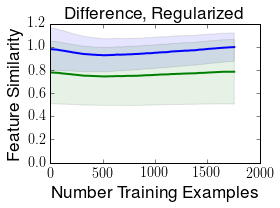

In [138]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0,0], 'k')

#plot(ntrain_x, train_hist, lw=0.2, label='Train')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 2000])

plt.tight_layout()



fname =  ('figures/trigram_diff_dict-reg-cycle=' + str(cycle) +'-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

## Trigram difference dictionary, unregularized


In [124]:
tst = time.time()

psi = np.zeros(N)
psi = train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])

# shouldn't this be {+1, -1}?
random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(test_pred, random_vecs)
    
    psi = train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/trigram_difference_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  768.251152039
data/trigram_difference_dict-unreg-N=20000-W=1758-170307.npz


figures/trigram_diff_dict-unreg-N=20000-W=1758-170307


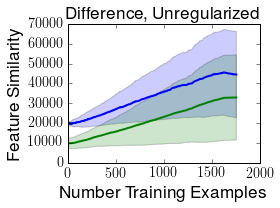

In [125]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)
test_mean = test_hist.mean(axis=1)
random_mean = random_hist.mean(axis=1)

train_std = np.nanstd(train_hist, axis=1) #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1) #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1) #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1
plot([0, 2000], [0,0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Unregularized')

xlim([0, 2000])

plt.tight_layout()

fname =  ('figures/trigram_diff_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

## Trigram difference dictionary, regularized

In [126]:
tst = time.time()
cycle = 1
psi = np.zeros(N)
psi = reg_train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/trigram_difference_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  776.933910131
data/trigram_difference_dict-reg-N=20000-W=1758-170307.npz


figures/trigram_diff_dict-reg-N=20000-W=1758-170307


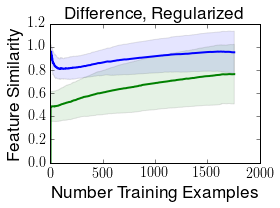

In [127]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0,0], 'k')

#plot(ntrain_x, train_hist, lw=0.2, label='Train')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 2000])

plt.tight_layout()



fname =  ('figures/trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/trigram_diff_dict-reg-N=20000-W=1758-170307


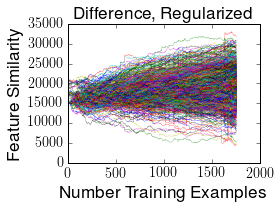

In [128]:
figure(figsize=(4,3))

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0,0], 'k')

plot(ntrain_x, train_hist, lw=0.2, label='Train')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 2000])

plt.tight_layout()



fname =  ('figures/trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

#plt.savefig(fname + '.png', transparent=True)
#plt.savefig(fname + '.eps', transparent=True)

figures/trigram_diff_dict-reg-N=20000-W=1758-170307


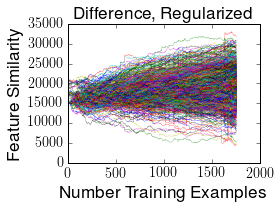

In [128]:
figure(figsize=(4,3))

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0,0], 'k')

plot(ntrain_x, test_hist, lw=0.2, label='Train')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 2000])

plt.tight_layout()



fname =  ('figures/trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

#plt.savefig(fname + '.png', transparent=True)
#plt.savefig(fname + '.eps', transparent=True)

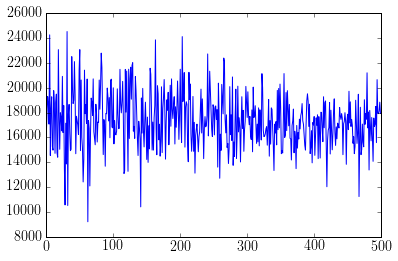

In [129]:
psi = np.zeros(N)
psi = reg_train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])

kmax=500
psi_mean = np.zeros(kmax)

for k in arange(1,kmax):
    psi_mean[k] = trainpres2[k].mean()
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])
    
    
train_pred = np.multiply(psi, trainpres1[:kmax]) + trainpres2[:kmax]

plot(sim(train_pred, trainpast2[:kmax]))

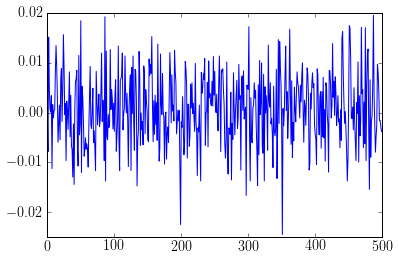

In [130]:
plot(psi_mean)

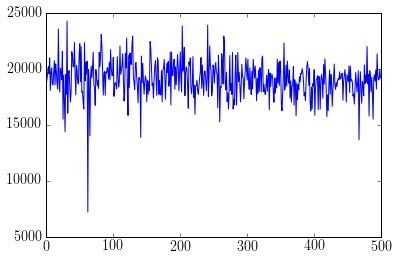

In [131]:
#psi = np.zeros(N)
psi = reg_train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])

kmax=500

for k in arange(1,kmax):
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])
    
train_pred = np.multiply(psi, trainpres1[:kmax]) + trainpres2[:kmax]

plot(sim(train_pred, trainpast2[:kmax]))


In [137]:
tst = time.time()

#psi = np.zeros(N)
cycle+=1

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(len(trainpres1)):#trainpres1.shape[0]):
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])
    
    train_pred = np.multiply(psi, trainpres1) + trainpres2
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :] = sim(train_pred, trainpast2)
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(test_pred, random_vecs)
    

    
print 'Elapsed: ', time.time() - tst

fname = ('data/trigram_difference_dict-reg-cycle=' + str(cycle) + '-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  1116.62421083
data/trigram_difference_dict-reg-cycle=3-N=20000-W=1758-170307.npz


figures/trigram_diff_dict-reg-cycle=3-N=20000-W=1758-170307


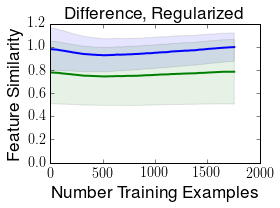

In [138]:
figure(figsize=(4,3))

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 2000], [0,0], 'k')

#plot(ntrain_x, train_hist, lw=0.2, label='Train')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 2000])

plt.tight_layout()



fname =  ('figures/trigram_diff_dict-reg-cycle=' + str(cycle) +'-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)